In [1]:
import pandas as pd
import numpy as np
import missingno as msno

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

from statsmodels.tsa.seasonal import seasonal_decompose

from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.serialize import model_to_json

import warnings
import itertools
warnings.filterwarnings("ignore")

c:\Users\Vinicius\Downloads\TC4\env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [60]:
# Carregar o arquivo CSV
file_path = './dataframe/preco_petroleo.csv'
df = pd.read_csv(file_path, delimiter=';', skiprows=1, header=None)
df.columns = ['ds', 'y']

# Converter a coluna 'ds' para datetime
df['ds'] = pd.to_datetime(df['ds'], format='%d/%m/%Y')

# Converter a coluna 'y' para float
df['y'] = df['y'].str.replace(',', '.').astype(float)

In [62]:
# Eventos relevantes com impacto nos preços do petróleo
eventos = {
    1987: '1.Crash da Bolsa de Valores de Wall Street',
    1990: '2.Invasão do Kuwait pelo Iraque',
    1997: '3.Crise financeira asiática',
    2001: '4.Ataques de 11 de setembro nos EUA',
    2003: '5.Guerra no Iraque',
    2005: '6.Furacão Katrina nos EUA',
    2006: '7.Crise do Campo Petrolífero de Prudhoe Bay',
    2008: '8.Crise financeira global e bolha imobiliária nos EUA',
    2009: '9.Revolução Verde no Irã', 
    2011: '10.Guerra Civil na Líbia', 
    2012: '11.Sanções Econômicas contra o Irã',
    2014: '12.Excesso de oferta global devido ao boom do shale oil nos EUA', 
    2015: '13.Acordo Nuclear com o Irã', 
    2018: '14.Guerra Comercial EUA-China',
    2019: '15.Ataques às Instalações de Petróleo Sauditas',
    2020: '16.Pandemia de COVID-19', 
    2022: '17.Invasão da Ucrânia pela Rússia e sanções subsequentes',
    
    
}

# Criar o gráfico de série temporal
fig = px.line(df, x='ds', y='y', title='Preço do Petróleo Brent (1987-2024)')

# Adicionar marcadores coloridos para eventos relevantes
for idx, (ano, evento) in enumerate(eventos.items(), 1):
    if isinstance(ano, str):
        # Eventos de longo prazo (intervalos de tempo)
        ano_inicio, ano_fim = map(int, ano.split('-'))
        price_range = df[(df['ds'].dt.year >= ano_inicio) & (df['ds'].dt.year <= ano_fim)]['y'].mean()
        trace = go.Scatter(x=[pd.to_datetime(f'{ano_inicio}-01-01'), pd.to_datetime(f'{ano_fim}-12-31')],
                        y=[price_range, price_range], mode='lines', name=evento)
        fig.add_trace(trace)
    else:
        # Eventos específicos (pontos)
        maior_valor_ano = df[df['ds'].dt.year == ano]['y'].idxmax()
        menor_valor_ano = df[df['ds'].dt.year == ano]['y'].idxmin()
        maior_valor = df.loc[maior_valor_ano, 'y']
        menor_valor = df.loc[menor_valor_ano, 'y']
        fig.add_trace(go.Scatter(x=[df.loc[maior_valor_ano, 'ds']],
                                y=[maior_valor, menor_valor],
                                mode='markers+text',
                                name=evento,
                                marker=dict(color='#8c8787', size=15),
                                text=f'{idx}',
                                textposition='top center'))

# Configurar títulos e legendas
fig.update_traces(line=dict(color='#FF4B4B'), hovertemplate='Data: %{x|%d-%m-%Y}<br>Preço: %{y}')
fig.update_layout(xaxis_title='Ano', 
                yaxis_title='Preço (USD)', 
                paper_bgcolor='#d2d0d0',
                showlegend=False
                )



fig.show()

In [32]:
# Evento específico de interesse
evento = {
    'evento': 'Crash da Bolsa de Valores de Wall Street',
    'ano': 1987
}

# Filtrar os dados para o ano específico do evento
data_evento = data[data['ds'].dt.year == evento['ano']]

# Encontrar a data do Crash da Bolsa de Valores de Wall Street (19 de outubro de 1987)
data_crash = data_evento[data_evento['ds'].dt.day == 19].iloc[2]

# Encontrar o menor valor de preço do ano
menor_valor_ano = data_evento['y'].min()
data_menor_valor_ano = data_evento[data_evento['y'] == menor_valor_ano].iloc[0]

# Criar o gráfico de série temporal para o evento específico
fig = go.Figure()

# Adicionar linha do preço ao longo do evento
fig.add_trace(go.Scatter(x=data_evento['ds'], y=data_evento['y'], mode='lines', name='Preço do Petróleo'))

# Adicionar marcador para o Crash da Bolsa de Valores de Wall Street
fig.add_trace(go.Scatter(x=[data_crash['ds']], y=[data_crash['y']],
                        mode='markers', name='Crash da Bolsa de Valores de Wall Street',
                        marker=dict(color='#363636', size=15)))

# Adicionar marcador para o menor valor do ano
fig.add_trace(go.Scatter(x=[data_menor_valor_ano['ds']], y=[data_menor_valor_ano['y']],
                        mode='markers', name='Menor valor causado pelo evento',
                        marker=dict(color='#800000', size=15)))

# Configurar título e eixos
fig.update_traces(line=dict(color='#FF4B4B'), hovertemplate='Data: %{x|%d-%m-%Y}<br>Preço: %{y}')  
fig.update_layout(title=f'Preço do Petróleo Brent - {evento["evento"]} ({evento["ano"]})',
                xaxis_title='Data', 
                yaxis_title='Preço (USD)', 
                paper_bgcolor='#d2d0d0',
                xaxis=dict(tickformat='%B-%Y'),
                legend=dict(orientation="h", yanchor="top", y=1.1, xanchor="center", x=0.5),
                
                )
fig.show()

In [33]:
# Evento específico de interesse
evento = {
    'evento': 'Invasão do Kuwait pelo Iraque',
    'ano': 1990
}

# Filtrar os dados para o ano específico do evento
data_evento = data[data['ds'].dt.year == evento['ano']]

# Encontrar a data do Crash da Bolsa de Valores de Wall Street (19 de outubro de 1987)
data_crash = data_evento[data_evento['ds'].dt.month == 7].iloc[0]

# Encontrar o menor valor de preço do ano
maior_valor_ano = data_evento['y'].max()
data_maior_valor_ano = data_evento[data_evento['y'] == maior_valor_ano].iloc[0]

# Criar o gráfico de série temporal para o evento específico
fig = go.Figure()

# Adicionar linha do preço ao longo do evento
fig.add_trace(go.Scatter(x=data_evento['ds'], y=data_evento['y'], mode='lines', name='Preço do Petróleo'))

# Adicionar marcador para o Crash da Bolsa de Valores de Wall Street
fig.add_trace(go.Scatter(x=[data_crash['ds']], y=[data_crash['y']],
                        mode='markers', name='Invasão do Kuwait pelo Iraque',
                        marker=dict(color='#363636', size=15)))

# Adicionar marcador para o menor valor do ano
fig.add_trace(go.Scatter(x=[data_maior_valor_ano['ds']], y=[data_maior_valor_ano['y']],
                        mode='markers', name='Maior valor causado pelo evento',
                        marker=dict(color='#800000', size=15)))

# Configurar título e eixos
fig.update_traces(line=dict(color='#FF4B4B'), hovertemplate='Data: %{x|%d-%m-%Y}<br>Preço: %{y}')  
fig.update_layout(title=f'Preço do Petróleo Brent - {evento["evento"]} ({evento["ano"]})',
                xaxis_title='Data', 
                yaxis_title='Preço (USD)', 
                paper_bgcolor='#d2d0d0',
                xaxis=dict(tickformat='%B-%Y'),
                legend=dict(orientation="h", yanchor="top", y=1.1, xanchor="center", x=0.5),
                
                )
fig.show()

In [34]:
# Evento específico de interesse
evento = {
    'evento': 'Crise financeira asiática',
    'ano': 1997
}

# Filtrar os dados para o ano específico do evento
data_evento = data[data['ds'].dt.year == evento['ano']]

# Encontrar o menor valor de preço do ano
menor_valor_ano = data_evento['y'].min()
data_menor_valor_ano = data_evento[data_evento['y'] == menor_valor_ano].iloc[0]

# Encontrar o maior valor de preço do ano
maior_valor_ano = data_evento['y'].max()
data_maior_valor_ano = data_evento[data_evento['y'] == maior_valor_ano].iloc[0]

# Definir os limites do eixo x com base nas datas filtradas
xlim_min = data_evento['ds'].min()
xlim_max = data_evento['ds'].max()

# Criar o gráfico de série temporal para o evento específico
fig = go.Figure()

# Adicionar linha do preço ao longo do evento
fig.add_trace(go.Scatter(x=data_evento['ds'], y=data_evento['y'], mode='lines', name='Preço do Petróleo'))

# Adicionar marcador para o menor valor do ano
fig.add_trace(go.Scatter(x=[data_menor_valor_ano['ds']], y=[data_menor_valor_ano['y']],
                        mode='markers', name='Fim da Crise',
                        marker=dict(color='#363636', size=15)))

# Adicionar marcador para o maior valor do ano
fig.add_trace(go.Scatter(x=[data_maior_valor_ano['ds']], y=[data_maior_valor_ano['y']],
                        mode='markers', name='Inicio da Crise',
                        marker=dict(color='#800000', size=15)))

# Configurar título e eixos
fig.update_traces(line=dict(color='#FF4B4B'), hovertemplate='Data: %{x|%d-%m-%Y}<br>Preço: %{y}')
fig.update_layout(title=f'Preço do Petróleo Brent - {evento["evento"]} ({evento["ano"]})',
                xaxis_title='Data',
                yaxis_title='Preço (USD)',
                paper_bgcolor='#d2d0d0',
                xaxis=dict(range=[xlim_min, xlim_max], tickformat='%B-%Y'),
                legend=dict(orientation="h", yanchor="top", y=1.1, xanchor="center", x=0.5),
                )
fig.show()

In [35]:
# Evento específico de interesse
evento = {
    'evento': 'Ataques de 11 de setembro nos EUA',
    'ano': 2001
}

# Filtrar os dados para o ano específico do evento
data_evento = data[data['ds'].dt.year == evento['ano']]

# Encontrar a data do menor valor de preço do ano
menor_valor_ano = data_evento['y'].min()
data_menor_valor_ano = data_evento[data_evento['y'] == menor_valor_ano].iloc[0]

# Encontrar a data do dia 11 de setembro
data_11_setembro = data_evento[(data_evento['ds'].dt.month == 9) & (data_evento['ds'].dt.day == 11)]

# Verificar se a data do dia 11 de setembro está presente
if not data_11_setembro.empty:
    data_11_setembro = data_11_setembro.iloc[0]
else:
    data_11_setembro = None

# Criar o gráfico de série temporal para o evento específico
fig = go.Figure()

# Adicionar linha do preço ao longo do evento
fig.add_trace(go.Scatter(x=data_evento['ds'], y=data_evento['y'], mode='lines', name='Preço do Petróleo'))

# Adicionar marcador para o dia 11 de setembro, se disponível
if data_11_setembro is not None:
    fig.add_trace(go.Scatter(x=[data_11_setembro['ds']], y=[data_11_setembro['y']],
                            mode='markers', name='11 de Setembro',
                            marker=dict(color='#363636', size=15)))

# Adicionar marcador para o menor valor do ano
fig.add_trace(go.Scatter(x=[data_menor_valor_ano['ds']], y=[data_menor_valor_ano['y']],
                        mode='markers', name='Menor valor do ano',
                        marker=dict(color='#800000', size=15)))

# Configurar título e eixos
fig.update_traces(line=dict(color='#FF4B4B'), hovertemplate='Data: %{x|%d-%m-%Y}<br>Preço: %{y}')  
fig.update_layout(title=f'Preço do Petróleo Brent - {evento["evento"]} ({evento["ano"]})',
                xaxis_title='Data', 
                yaxis_title='Preço (USD)', 
                paper_bgcolor='#d2d0d0',
                xaxis=dict(tickformat='%B-%Y'),
                legend=dict(orientation="h", yanchor="top", y=1.1, xanchor="center", x=0.5),
                )
fig.show()

In [36]:
# Evento específico de interesse
evento = {
    'evento': 'Guerra no Iraque',
    'ano': 2003
}

# Filtrar os dados para o ano específico do evento
data_evento = data[data['ds'].dt.year == evento['ano']]

# Encontrar o menor valor de preço em maio de 2003
menor_valor_maio = data_evento[data_evento['ds'].dt.month == 5]['y'].min()
data_menor_valor_maio = data_evento[(data_evento['ds'].dt.month == 5) & (data_evento['y'] == menor_valor_maio)]

# Criar o gráfico de série temporal para o evento específico
fig = go.Figure()

# Adicionar linha do preço ao longo do evento
fig.add_trace(go.Scatter(x=data_evento['ds'], y=data_evento['y'], mode='lines', name='Preço do Petróleo'))

# Adicionar marcador para o evento em 1º de março
primeiro_de_marco = data_evento[data_evento['ds'].dt.month == 3].iloc[0]
fig.add_trace(go.Scatter(x=[primeiro_de_marco['ds']], y=[primeiro_de_marco['y']],
                        mode='markers', name=f'Inicio da guerra',
                        marker=dict(color='#363636', size=15)))

# Adicionar marcador para o menor valor de maio
fig.add_trace(go.Scatter(x=[data_menor_valor_maio['ds'].iloc[0]], y=[data_menor_valor_maio['y'].iloc[0]],
                        mode='markers', name=f'Queda mais acentuada do período',
                        marker=dict(color='#800000', size=15)))

# Configurar título e eixos


fig.update_traces(line=dict(color='#FF4B4B'), hovertemplate='Data: %{x|%d-%m-%Y}<br>Preço: %{y}')  
fig.update_layout(title=f'Preço do Petróleo Brent - {evento["evento"]} ({evento["ano"]})',
                xaxis_title='Data', 
                yaxis_title='Preço (USD)', 
                paper_bgcolor='#d2d0d0',
                xaxis=dict(tickformat='%B-%Y'),
                legend=dict(orientation="h", yanchor="top", y=1.1, xanchor="center", x=0.5),
                
                )
fig.show()

In [37]:
# Evento específico de interesse
evento = {
    'evento': 'Furacão Katrina nos EUA',
    'ano': 2005
}

# Filtrar os dados para o ano específico do evento
data_evento = data[data['ds'].dt.year == evento['ano']]

# Encontrar a data do menor valor de setembro
data_setembro = data_evento[data_evento['ds'].dt.month == 9]
menor_valor_setembro = data_setembro['y'].min()
data_menor_valor_setembro = data_setembro[data_setembro['y'] == menor_valor_setembro].iloc[0]

# Encontrar a data do dia 29 de agosto
data_furacao = data_evento[(data_evento['ds'].dt.month == 8) & (data_evento['ds'].dt.day == 29)].iloc[0]

# Criar o gráfico de série temporal para o evento específico
fig = go.Figure()

# Adicionar linha do preço ao longo do evento
fig.add_trace(go.Scatter(x=data_evento['ds'], y=data_evento['y'], mode='lines', name='Preço do Petróleo'))

# Adicionar marcador para o dia 29 de agosto
fig.add_trace(go.Scatter(x=[data_furacao['ds']], y=[data_furacao['y']],
                        mode='markers', name='Preço no Inicio do Furacão Katrina',
                        marker=dict(color='#363636', size=15)))

# Adicionar marcador para o menor valor de setembro
fig.add_trace(go.Scatter(x=[data_menor_valor_setembro['ds']], y=[data_menor_valor_setembro['y']],
                        mode='markers', name='Menor valor durante Evento',
                        marker=dict(color='#800000', size=15)))

# Configurar título e eixos
fig.update_traces(line=dict(color='#FF4B4B'), hovertemplate='Data: %{x|%d-%m-%Y}<br>Preço: %{y}')  
fig.update_layout(title=f'Preço do Petróleo Brent - {evento["evento"]} ({evento["ano"]})',
                xaxis_title='Data', 
                yaxis_title='Preço (USD)', 
                paper_bgcolor='#d2d0d0',
                xaxis=dict(tickformat='%B-%Y'),
                legend=dict(orientation="h", yanchor="top", y=1.1, xanchor="center", x=0.5),
                )

fig.show()

In [38]:
# Evento específico de interesse
evento = {
    'evento': 'Crise do Campo Petrolífero de Prudhoe Bay 2006',
    'ano': 2006
}

# Filtrar os dados para o ano específico do evento
data_evento = data[data['ds'].dt.year == evento['ano']]

# Encontrar a data do menor valor entre março e setembro
data_marco_setembro = data_evento[(data_evento['ds'].dt.month >= 3) & (data_evento['ds'].dt.month <= 9)]
menor_valor_marco_setembro = data_marco_setembro['y'].min()
data_menor_valor_marco_setembro = data_marco_setembro[data_marco_setembro['y'] == menor_valor_marco_setembro].iloc[0]

# Encontrar a data de 6 de março
data_6_marco = data_evento[(data_evento['ds'].dt.month == 3) & (data_evento['ds'].dt.day == 6)].iloc[0]

# Criar o gráfico de série temporal para o evento específico
fig = go.Figure()

# Adicionar linha do preço ao longo do evento
fig.add_trace(go.Scatter(x=data_evento['ds'], y=data_evento['y'], mode='lines', name='Preço do Petróleo'))

# Adicionar marcador para 6 de março
fig.add_trace(go.Scatter(x=[data_6_marco['ds']], y=[data_6_marco['y']],
                        mode='markers', name='Preço em 6 de Março',
                        marker=dict(color='#363636', size=15)))

# Adicionar marcador para o menor valor de março a setembro
fig.add_trace(go.Scatter(x=[data_menor_valor_marco_setembro['ds']], y=[data_menor_valor_marco_setembro['y']],
                        mode='markers', name='Menor valor durante o evento (Março-Setembro)',
                        marker=dict(color='#800000', size=15)))

# Configurar título e eixos
fig.update_traces(line=dict(color='#FF4B4B'), hovertemplate='Data: %{x|%d-%m-%Y}<br>Preço: %{y}')  
fig.update_layout(title=f'Preço do Petróleo Brent - {evento["evento"]} ({evento["ano"]})',
                xaxis_title='Data', 
                yaxis_title='Preço (USD)', 
                paper_bgcolor='#d2d0d0',
                xaxis=dict(tickformat='%B-%Y'),
                legend=dict(orientation="h", yanchor="top", y=1.1, xanchor="center", x=0.5),
                )
fig.show()

In [39]:
# Filtrar os dados para os anos de 2008 e 2009
data_2008_2009 = data[(data['ds'].dt.year >= 2008) & (data['ds'].dt.year <= 2009)]

# Encontrar a data do menor valor durante esses dois anos
menor_valor_2008_2009 = data_2008_2009['y'].min()
data_menor_valor_2008_2009 = data_2008_2009[data_2008_2009['y'] == menor_valor_2008_2009].iloc[0]

# Encontrar a data do primeiro dia de julho de 2008
data_primeiro_julho_2008 = data_2008_2009[(data_2008_2009['ds'].dt.year == 2008) & (data_2008_2009['ds'].dt.month == 7)].iloc[0]

# Criar o gráfico de série temporal
fig = go.Figure()

# Adicionar linha do preço ao longo dos anos de 2008 e 2009
fig.add_trace(go.Scatter(x=data_2008_2009['ds'], y=data_2008_2009['y'], mode='lines', name='Preço do Petróleo'))

# Adicionar marcador para o primeiro dia de julho de 2008
fig.add_trace(go.Scatter(x=[data_primeiro_julho_2008['ds']], y=[data_primeiro_julho_2008['y']],
                        mode='markers', name='Início da Crise em Julho de 2008',
                        marker=dict(color='#363636', size=15)))

# Adicionar marcador para o menor valor encontrado em 2008 e 2009
fig.add_trace(go.Scatter(x=[data_menor_valor_2008_2009['ds']], y=[data_menor_valor_2008_2009['y']],
                        mode='markers', name='Menor Valor durante a Crise',
                        marker=dict(color='#800000', size=15)))

# Configurar título e eixos
fig.update_traces(line=dict(color='#FF4B4B'), hovertemplate='Data: %{x|%d-%m-%Y}<br>Preço: %{y}')  
fig.update_layout(title='Preço do Petróleo Brent - Crise Financeira Global e Bolha Imobiliária nos EUA (2008-2009)',
                xaxis_title='Data', 
                yaxis_title='Preço (USD)', 
                paper_bgcolor='#d2d0d0',
                xaxis=dict(tickformat='%B-%Y'),
                legend=dict(orientation="h", yanchor="top", y=1.1, xanchor="center", x=0.5),
                )
fig.show()

In [40]:
# Evento específico de interesse
evento = {
    'evento': 'Revolução Verde no Irã',
    'ano': 2009
}

# Filtrar os dados para o ano específico do evento
data_evento = data[data['ds'].dt.year == evento['ano']]

# Encontrar a data do maior valor entre junho e agosto
data_junho_agosto = data_evento[(data_evento['ds'].dt.month >= 6) & (data_evento['ds'].dt.month <= 10)]
maior_valor_junho_agosto = data_junho_agosto['y'].max()
data_maior_valor_junho_agosto = data_junho_agosto[data_junho_agosto['y'] == maior_valor_junho_agosto].iloc[0]

# Encontrar a data do primeiro dia de junho
data_primeiro_junho = data_evento[(data_evento['ds'].dt.month == 6) & (data_evento['ds'].dt.day == 1)].iloc[0]

# Encontrar a data de 12 de junho de 2009
data_12_junho = data_evento[(data_evento['ds'].dt.month == 6) & (data_evento['ds'].dt.day == 12)].iloc[0]

# Encontrar o menor valor de julho de 2009
data_julho = data_evento[(data_evento['ds'].dt.month == 7)]
menor_valor_julho = data_julho['y'].min()
data_menor_valor_julho = data_julho[data_julho['y'] == menor_valor_julho].iloc[0]

# Criar o gráfico de série temporal para o evento específico
fig = go.Figure()

# Adicionar linha do preço ao longo do evento
fig.add_trace(go.Scatter(x=data_evento['ds'], y=data_evento['y'], mode='lines', name='Preço do Petróleo'))

# Adicionar marcador para o dia 12 de junho de 2009
fig.add_trace(go.Scatter(x=[data_12_junho['ds']], y=[data_12_junho['y']],
                        mode='markers', name='12 de Junho de 2009',
                        marker=dict(color='#363636', size=15)))

# Adicionar marcador para o menor valor de julho
fig.add_trace(go.Scatter(x=[data_menor_valor_julho['ds']], y=[data_menor_valor_julho['y']],
                        mode='markers', name='Pico de queda em Julho',
                        marker=dict(color='#000080', size=15)))

# Adicionar marcador para o maior valor entre junho e agosto
fig.add_trace(go.Scatter(x=[data_maior_valor_junho_agosto['ds']], y=[data_maior_valor_junho_agosto['y']],
                        mode='markers', name='Maior valor durante evento',
                        marker=dict(color='#800000', size=15)))

# Configurar título e eixos
fig.update_traces(line=dict(color='#FF4B4B'), hovertemplate='Data: %{x|%d-%m-%Y}<br>Preço: %{y}')  
fig.update_layout(title=f'Preço do Petróleo Brent - {evento["evento"]} ({evento["ano"]})',
                xaxis_title='Data', 
                yaxis_title='Preço (USD)', 
                paper_bgcolor='#d2d0d0',
                xaxis=dict(tickformat='%B-%Y'),
                legend=dict(orientation="h", yanchor="top", y=1.1, xanchor="center", x=0.5),
                )
fig.show()

In [41]:
# Evento específico de interesse
evento = {
    'evento': 'Guerra Civil na Líbia',
    'ano': 2011
}

# Filtrar os dados para o ano específico do evento
data_evento = data[data['ds'].dt.year == evento['ano']]

# Encontrar a data do primeiro dia de fevereiro
data_primeiro_fevereiro = data_evento[(data_evento['ds'].dt.month == 2) & (data_evento['ds'].dt.day == 1)].iloc[0]

# Encontrar a data do maior valor entre fevereiro e outubro
data_fevereiro_outubro = data_evento[(data_evento['ds'].dt.month >= 2) & (data_evento['ds'].dt.month <= 10)]
maior_valor_fevereiro_outubro = data_fevereiro_outubro['y'].max()
data_maior_valor_fevereiro_outubro = data_fevereiro_outubro[data_fevereiro_outubro['y'] == maior_valor_fevereiro_outubro].iloc[0]

# Encontrar a data do dia 1 de março
data_primeiro_marco = data_evento[(data_evento['ds'].dt.month == 3) & (data_evento['ds'].dt.day == 1)].iloc[0]

# Criar o gráfico de série temporal para o evento específico
fig = go.Figure()

# Adicionar linha do preço ao longo do evento
fig.add_trace(go.Scatter(x=data_evento['ds'], y=data_evento['y'], mode='lines', name='Preço do Petróleo'))

# Adicionar marcador para o primeiro dia de fevereiro
fig.add_trace(go.Scatter(x=[data_primeiro_fevereiro['ds']], y=[data_primeiro_fevereiro['y']],
                        mode='markers', name='Início de Guerra Civil na Líbia',
                        marker=dict(color='#363636', size=15)))

# Adicionar marcador para o maior valor entre fevereiro e outubro
fig.add_trace(go.Scatter(x=[data_maior_valor_fevereiro_outubro['ds']], y=[data_maior_valor_fevereiro_outubro['y']],
                        mode='markers', name='Maior valor durante Evento',
                        marker=dict(color='#800000', size=15)))

# Adicionar marcador para o dia 1 de março
fig.add_trace(go.Scatter(x=[data_primeiro_marco['ds']], y=[data_primeiro_marco['y']],
                        mode='markers', name='2 meses apos inicio da guerra',
                        marker=dict(color='#000080', size=15)))

# Configurar título e eixos
fig.update_traces(line=dict(color='#FF4B4B'), hovertemplate='Data: %{x|%d-%m-%Y}<br>Preço: %{y}')  
fig.update_layout(title=f'Preço do Petróleo Brent - {evento["evento"]} ({evento["ano"]})',
                xaxis_title='Data', 
                yaxis_title='Preço (USD)', 
                paper_bgcolor='#d2d0d0',
                xaxis=dict(tickformat='%B-%Y'),
                legend=dict(orientation="h", yanchor="top", y=1.15, xanchor="center", x=0.5),
                )
fig.show()

In [42]:
# Evento específico de interesse
evento = {
    'evento': 'Sanções Econômicas contra o Irã',
    'ano': 2012
}

# Filtrar os dados para o ano específico do evento
data_evento = data[data['ds'].dt.year == evento['ano']]

# Encontrar a data do maior valor em janeiro
data_maior_janeiro = data_evento[data_evento['ds'].dt.month == 1].nlargest(1, 'y')

# Encontrar a data do menor valor do ano
data_menor_ano = data_evento.nsmallest(1, 'y')

# Definir os limites do eixo x com base nas datas filtradas
xlim_min = data_evento['ds'].min()
xlim_max = data_evento['ds'].max()


# Criar o gráfico de série temporal para o evento específico
fig = go.Figure()

# Adicionar linha do preço ao longo do evento
fig.add_trace(go.Scatter(x=data_evento['ds'], y=data_evento['y'], mode='lines', name='Preço do Petróleo'))

# Adicionar marcador para o maior valor de janeiro
fig.add_trace(go.Scatter(x=data_maior_janeiro['ds'], y=data_maior_janeiro['y'],
                        mode='markers', name='Inicio das sanções econômicas',
                        marker=dict(color='#363636', size=15)))

# Adicionar marcador para o menor valor do ano
fig.add_trace(go.Scatter(x=data_menor_ano['ds'], y=data_menor_ano['y'],
                        mode='markers', name='Maior queda durante Evento',
                        marker=dict(color='#800000', size=15)))



# Configurar título e eixos
fig.update_traces(line=dict(color='#FF4B4B'), hovertemplate='Data: %{x|%d-%m-%Y}<br>Preço: %{y}')
fig.update_layout(title=f'Preço do Petróleo Brent - {evento["evento"]} ({evento["ano"]})',
                xaxis_title='Data',
                yaxis_title='Preço (USD)',
                paper_bgcolor='#d2d0d0',
                xaxis=dict(range=[xlim_min, xlim_max], tickformat='%B-%Y'),
                legend=dict(orientation="h", yanchor="top", y=1.1, xanchor="center", x=0.5),
                )
fig.show()

In [43]:
# Evento específico de interesse
evento = {
    'evento': 'Excesso de oferta global devido ao boom do shale oil nos EUA',
    'ano': 2014
}

# Filtrar os dados para o ano de 2014
data_evento = data[data['ds'].dt.year == 2014]

# Encontrar a data do maior valor em 2014
data_maior_2014 = data_evento.nlargest(1, 'y')

# Encontrar a data do menor valor em 2014
data_menor_2014 = data_evento.nsmallest(1, 'y')

# Definir os limites do eixo x com base nas datas filtradas
xlim_min = data_evento['ds'].min()
xlim_max = data_evento['ds'].max()

# Criar o gráfico de série temporal para o evento específico
fig = go.Figure()

# Adicionar linha do preço ao longo do evento
fig.add_trace(go.Scatter(x=data_evento['ds'], y=data_evento['y'], mode='lines', name='Preço do Petróleo'))

# Adicionar marcador para o maior valor em 2014
fig.add_trace(go.Scatter(x=data_maior_2014['ds'], y=data_maior_2014['y'],
                        mode='markers', name='Inicio do Evento',
                        marker=dict(color='#363636', size=15)))

# Adicionar marcador para o menor valor em 2014
fig.add_trace(go.Scatter(x=data_menor_2014['ds'], y=data_menor_2014['y'],
                        mode='markers', name='Maior queda durante Evento',
                        marker=dict(color='#800000', size=15)))

# Configurar título e eixos
fig.update_traces(line=dict(color='#FF4B4B'), hovertemplate='Data: %{x|%d-%m-%Y}<br>Preço: %{y}')
fig.update_layout(title=f'Preço do Petróleo Brent - {evento["evento"]} (2014)',
                xaxis_title='Data',
                yaxis_title='Preço (USD)',
                paper_bgcolor='#d2d0d0',
                xaxis=dict(range=[xlim_min, xlim_max], tickformat='%d-%m-%Y'),
                legend=dict(orientation="h", yanchor="top", y=1.1, xanchor="center", x=0.5),
                )
fig.show()


In [44]:
# Evento específico de interesse
evento = {
    'evento': 'Acordo Nuclear com o Irã',
    'ano': 2015
}

# Filtrar os dados para o período específico do evento
data_evento = data[(data['ds'] >= '2015-01-01') & (data['ds'] <= '2016-02-29')]

# Encontrar a data do maior valor em julho
data_maior_julho = data_evento[(data_evento['ds'].dt.month == 7) & (data_evento['ds'].dt.day == 14)].nsmallest(1, 'y')
data_menor_ano = data_evento.nsmallest(1, 'y')

# Definir os limites do eixo x com base nas datas filtradas
xlim_min = data_evento['ds'].min()
xlim_max = data_evento['ds'].max()

# Criar o gráfico de série temporal para o evento específico
fig = go.Figure()

# Adicionar linha do preço ao longo do evento
fig.add_trace(go.Scatter(x=data_evento['ds'], y=data_evento['y'], mode='lines', name='Preço do Petróleo'))

# Adicionar marcador para o início do evento (14 de julho)
fig.add_trace(go.Scatter(x=data_maior_julho['ds'], y=data_maior_julho['y'],
                        mode='markers', name='Assinatura do Acordo',
                        marker=dict(color='#363636', size=15)))

# Adicionar marcador para o menor valor do ano durante o evento
fig.add_trace(go.Scatter(x=data_menor_ano['ds'], y=data_menor_ano['y'],
                        mode='markers', name='Menor valor durante Evento',
                        marker=dict(color='#800000', size=15)))

# Configurar título e eixos
fig.update_traces(line=dict(color='#FF4B4B'), hovertemplate='Data: %{x|%d-%m-%Y}<br>Preço: %{y}')
fig.update_layout(title=f'Preço do Petróleo Brent - {evento["evento"]} ({evento["ano"]})',
                xaxis_title='Data',
                yaxis_title='Preço (USD)',
                paper_bgcolor='#d2d0d0',
                xaxis=dict(range=[xlim_min, xlim_max], tickformat='%B-%Y'),
                legend=dict(orientation="h", yanchor="top", y=1.1, xanchor="center", x=0.5),
                )
fig.show()


In [45]:
# Evento específico de interesse
evento = {
    'evento': 'OPEP e Produção dos EUA: Impactos na Queda dos Preços do Petróleo Brent',
    'ano': 2018
}

# Filtrar os dados para o período de janeiro de 2018 a fevereiro de 2019
data_evento = data[(data['ds'] >= '2018-01-01') & (data['ds'] <= '2019-02-28')]

# Encontrar a data do maior valor de janeiro de 2018
data_maior_janeiro = data_evento[(data_evento['ds'].dt.year == 2018) & (data_evento['ds'].dt.month == 1)].nlargest(1, 'y')

# Encontrar a data do menor valor do ano de 2018-2019
data_menor_ano = data_evento.nsmallest(1, 'y')

# Definir os limites do eixo x com base nas datas filtradas
xlim_min = data_evento['ds'].min()
xlim_max = data_evento['ds'].max()

# Criar o gráfico de série temporal para o evento específico
fig = go.Figure()

# Adicionar linha do preço ao longo do evento
fig.add_trace(go.Scatter(x=data_evento['ds'], y=data_evento['y'], mode='lines', name='Preço do Petróleo'))

# Adicionar marcador para 01/10/2018 (outubro de 2018)
fig.add_trace(go.Scatter(x=['2018-10-01'], y=[data_evento[data_evento['ds'] == '2018-10-01']['y'].values[0]],
                        mode='markers', name='Aumento da produção de Petróleo',
                        marker=dict(color='#363636', size=15)))

# Adicionar marcador para o menor valor do ano
fig.add_trace(go.Scatter(x=data_menor_ano['ds'], y=data_menor_ano['y'],
                        mode='markers', name='Menor Valor durante o acordo',
                        marker=dict(color='#800000', size=15)))

# Configurar título e eixos
fig.update_traces(line=dict(color='#FF4B4B'), hovertemplate='Data: %{x|%d-%m-%Y}<br>Preço: %{y}')
fig.update_layout(title=f'Preço do Petróleo Brent - {evento["evento"]} (2018 a 2019)',
                xaxis_title='Data',
                yaxis_title='Preço (USD)',
                paper_bgcolor='#d2d0d0',
                xaxis=dict(range=[xlim_min, xlim_max], tickformat='%B-%Y'),
                legend=dict(orientation="h", yanchor="top", y=1.1, xanchor="center", x=0.5),
                )
fig.show()

In [46]:
# Evento específico de interesse
evento = {
    'evento': 'Ataques às Instalações de Petróleo Sauditas',
    'ano': 2019
}

# Filtrar os dados para o ano de 2019
data_evento = data[(data['ds'].dt.year == 2019)]

# Encontrar a data do maior valor durante setembro de 2019
data_maior_setembro = data_evento[(data_evento['ds'] >= '2019-09-01') & (data_evento['ds'] <= '2019-09-30')].nlargest(1, 'y')

# Criar o gráfico de série temporal para o evento específico
fig = go.Figure()

# Adicionar linha do preço ao longo do evento
fig.add_trace(go.Scatter(x=data_evento['ds'], y=data_evento['y'], mode='lines', name='Preço do Petróleo'))

# Adicionar marcador para 12/09/2019
fig.add_trace(go.Scatter(x=['2019-09-12'], y=[data_evento[data_evento['ds'] == '2019-09-12']['y'].values[0]],
                        mode='markers', name='Ataques às Instalações de Petróleo Sauditas',
                        marker=dict(color='#363636', size=15)))

# Adicionar marcador para o maior valor durante setembro de 2019
fig.add_trace(go.Scatter(x=data_maior_setembro['ds'], y=data_maior_setembro['y'],
                        mode='markers', name='Aumento nos preços devido ao Evento',
                        marker=dict(color='#800000', size=15)))

# Configurar título e eixos
fig.update_traces(line=dict(color='#FF4B4B'), hovertemplate='Data: %{x|%d-%m-%Y}<br>Preço: %{y}')
fig.update_layout(title=f'Preço do Petróleo Brent - {evento["evento"]} (2019)',
                xaxis_title='Data',
                yaxis_title='Preço (USD)',
                paper_bgcolor='#d2d0d0',
                xaxis=dict(tickformat='%d-%m-%Y'),
                legend=dict(orientation="h", yanchor="top", y=1.1, xanchor="center", x=0.5),
                )
fig.show()

In [47]:
# Evento específico de interesse
evento = {
    'evento': 'Pandemia de COVID-19',
    'ano': 2020
}

# Filtrar os dados para o ano de 2020
data_evento = data[(data['ds'].dt.year == 2020)]

# Encontrar a data de 11 de março de 2020
data_11_marco = data_evento[data_evento['ds'] == '2020-03-02']

# Encontrar o menor valor do ano de 2020
menor_valor_2020 = data_evento.nsmallest(1, 'y')

# Criar o gráfico de série temporal para o evento específico
fig = go.Figure()

# Adicionar linha do preço ao longo do evento
fig.add_trace(go.Scatter(x=data_evento['ds'], y=data_evento['y'], mode='lines', name='Preço do Petróleo'))

# Adicionar marcador para 11 de março de 2020
fig.add_trace(go.Scatter(x=data_11_marco['ds'], y=data_11_marco['y'],
                        mode='markers', name='Inicio da Pandemia COVID-19',
                        marker=dict(color='#363636', size=15)))

# Adicionar marcador para o menor valor do ano de 2020
fig.add_trace(go.Scatter(x=menor_valor_2020['ds'], y=menor_valor_2020['y'],
                        mode='markers', name='Pico de queda durante pandemia',
                        marker=dict(color='#800000', size=15)))

# Configurar título e eixos
fig.update_traces(line=dict(color='#FF4B4B'), hovertemplate='Data: %{x|%d-%m-%Y}<br>Preço: %{y}')
fig.update_layout(title=f'Preço do Petróleo Brent - {evento["evento"]} ({evento["ano"]})',
                xaxis_title='Data',
                yaxis_title='Preço (USD)',
                paper_bgcolor='#d2d0d0',
                xaxis=dict(tickformat='%B-%Y'),
                legend=dict(orientation="h", yanchor="top", y=1.1, xanchor="center", x=0.5),
                )
fig.show()

In [48]:
# Evento específico de interesse
evento = {
    'evento': 'Invasão da Ucrânia pela Rússia e sanções subsequentes',
    'ano': '2022-2024'
}

# Filtrar os dados para o período de 2022 até o período atual
data_evento = data[data['ds'].dt.year >= 2022]

# Encontrar o maior valor de março de 2022
maior_valor_marco_2022 = data_evento[(data_evento['ds'].dt.year == 2022) & (data_evento['ds'].dt.month == 3)].nlargest(1, 'y')

# Encontrar o menor valor entre 2022 e 2024
menor_valor_2022_2024 = data_evento[(data_evento['ds'].dt.year >= 2022) & (data_evento['ds'].dt.year <= 2024)].nsmallest(1, 'y')

# Criar o gráfico de série temporal para o evento específico
fig = go.Figure()

# Adicionar linha do preço ao longo do evento
fig.add_trace(go.Scatter(x=data_evento['ds'], y=data_evento['y'], mode='lines', name='Preço do Petróleo'))

# Adicionar marcador para o maior valor de março de 2022
fig.add_trace(go.Scatter(x=maior_valor_marco_2022['ds'], y=maior_valor_marco_2022['y'],
                        mode='markers', name='Sanções Econômicas Contra Russia',
                        marker=dict(color='#363636', size=15)))

# Adicionar marcador para o menor valor entre 2022 e 2024
fig.add_trace(go.Scatter(x=menor_valor_2022_2024['ds'], y=menor_valor_2022_2024['y'],
                        mode='markers', name='Menos valor durante período do Evento',
                        marker=dict(color='#800000', size=15)))

# Configurar título e eixos
fig.update_traces(line=dict(color='#FF4B4B'), hovertemplate='Data: %{x|%d-%m-%Y}<br>Preço: %{y}')
fig.update_layout(title=f'Preço do Petróleo Brent - {evento["evento"]} ({evento["ano"]})',
                xaxis_title='Data',
                yaxis_title='Preço (USD)',
                paper_bgcolor='#d2d0d0',
                xaxis=dict(tickformat='%B-%Y'),
                legend=dict(orientation="h", yanchor="top", y=1.1, xanchor="center", x=0.5),
                )
fig.show()

<Axes: >

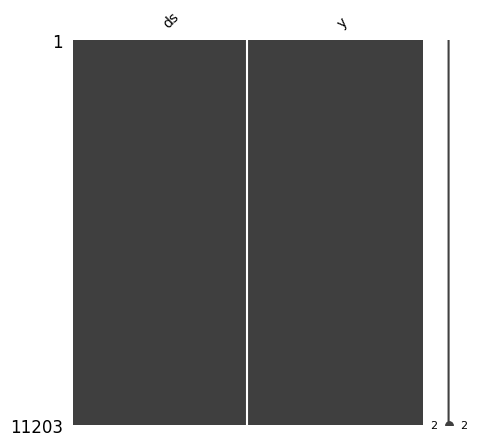

In [14]:
msno.matrix(df, figsize=(5,5), fontsize=10)

In [49]:
df_desbribe = df.describe()
# Renomear as medidas
df_desbribe = df_desbribe.rename(index={
    "count": "Quantidade de Linhas",
    "mean": "Media",
    "std": "Desvio Padrão",
    "min": "Minima no período",
    "25%": "1º Quartil",
    "50%": "Mediana",
    "75%": "3º quartil",
    "max": "Maxima no período"
    })
medida_count = df_desbribe.loc["Quantidade de Linhas"]["y"]
medida_mean = df_desbribe.loc["Media"]["y"]
medida_std = df_desbribe.loc["Desvio Padrão"]["y"]
medida_min = df_desbribe.loc["Minima no período"]["y"]
medida_25 = df_desbribe.loc["1º Quartil"]["y"]
medida_50 = df_desbribe.loc["Mediana"]["y"]
medida_75 = df_desbribe.loc["3º quartil"]["y"]
medida_max = df_desbribe.loc["Maxima no período"]["y"]
df_desbribe.reset_index(inplace=True)
df_desbribe.columns = ["Medidas", "abc","Preço do barril de petróleo"]
df_desbribe = df_desbribe.drop('abc',axis=1)
df_desbribe

Medidas  Preço do barril de petróleo
0  Quantidade de Linhas                 11203.000000
1                 Media                    53.110478
2     Minima no período                     9.100000
3            1º Quartil                    20.530000
4               Mediana                    48.400000
5            3º quartil                    76.610000
6     Maxima no período                   143.950000
7         Desvio Padrão                    33.215821

In [9]:
# Criando o histograma com Plotly Express
fig = px.histogram(df, x='y', nbins=14, 
                title='Histograma dos Preços do Petróleo Brent',
                color_discrete_sequence=['#8c8787'])

# Atualizando o layout do gráfico
fig.update_layout(
    xaxis_title='Preço',
    yaxis_title='Recorrência das Faixas de Preço',
    paper_bgcolor='#d2d0d0',
)
# Atualizando a cor das barras
fig.update_traces(marker_color='#FF4B4B')

fig.show()

In [10]:
# Carregar o arquivo CSV
file_path = './dataframe/preco_petroleo.csv'
df = pd.read_csv(file_path, delimiter=';', skiprows=1, header=None)
df.columns = ['ds', 'y']

# Converter a coluna 'ds' para datetime
df['ds'] = pd.to_datetime(df['ds'], format='%d/%m/%Y')

# Converter a coluna 'y' para float
df['y'] = df['y'].str.replace(',', '.').astype(float)

# Filtrar os dados de 2020 até hoje
df_filtrado = df.loc[df['ds'] >= '2020-01-01']

# Calcular as médias móveis
df_filtrado['Média Móvel (30 dias)'] = df_filtrado['y'].rolling(window=30).mean()
df_filtrado['Média Móvel (90 dias)'] = df_filtrado['y'].rolling(window=90).mean()
df_filtrado['Média Móvel (180 dias)'] = df_filtrado['y'].rolling(window=180).mean()

# Plotar o gráfico com Plotly
fig = go.Figure()

# Adicionar as séries temporais originais
fig.add_trace(go.Scatter(x=df_filtrado['ds'], y=df_filtrado['y'], mode='lines', name='Preço Diário', line=dict(color='blue')))

# Adicionar as médias móveis
fig.add_trace(go.Scatter(x=df_filtrado['ds'], y=df_filtrado['Média Móvel (30 dias)'], mode='lines', name='Média Móvel (30 dias)', line=dict(color='red')))
fig.add_trace(go.Scatter(x=df_filtrado['ds'], y=df_filtrado['Média Móvel (90 dias)'], mode='lines', name='Média Móvel (90 dias)', line=dict(color='green')))
fig.add_trace(go.Scatter(x=df_filtrado['ds'], y=df_filtrado['Média Móvel (180 dias)'], mode='lines', name='Média Móvel (180 dias)', line=dict(color='purple')))

# Configurar o layout do gráfico
fig.update_layout(title='Análise de Médias Móveis do Preço do Petróleo Brent (2020 - Hoje)',
                    xaxis_title='Data',
                    yaxis_title='Preço (USD)',
                    paper_bgcolor='#d2d0d0',
                    xaxis=dict(tickformat='%Y'),
                    legend=dict(orientation="h", yanchor="top", y=1.1, xanchor="center", x=0.5),
                    )
fig.show()

In [50]:
# Definir a coluna 'ds' como índice
df.set_index('ds', inplace=True)

# Calculando desvio padrão e volatilidade
df['Desvio Padrão (30 dias)'] = df['y'].rolling(window=30).std()

# Criar a figura do Plotly
fig = go.Figure()
fig.add_trace(go.Scatter(x=df.index, y=df['y'], mode='lines', name='Preço Diário', line=dict(color='#FF4B4B')))
fig.add_trace(go.Scatter(x=df.index, y=df['Desvio Padrão (30 dias)'], mode='lines', name='Desvio Padrão (30 dias)', line=dict(color='blue')))

# Atualizar o layout da figura
fig.update_layout(
    title='Análise de Volatilidade do Preço do Petróleo Brent',
    xaxis_title='Data',
    yaxis_title='Preço (USD) / Desvio Padrão',
    template='plotly_white',
    paper_bgcolor='#d2d0d0',
    xaxis=dict(tickformat='%Y'),
    legend=dict(orientation="h", yanchor="top", y=1.1, xanchor="center", x=0.5),
)
fig.show()

In [12]:
# Carregar o arquivo CSV
file_path = './dataframe/preco_petroleo.csv'
df = pd.read_csv(file_path, delimiter=';', skiprows=1, header=None)
df.columns = ['ds', 'y']

# Converter a coluna 'ds' para datetime
df['ds'] = pd.to_datetime(df['ds'], format='%d/%m/%Y')

# Converter a coluna 'y' para float
df['y'] = df['y'].str.replace(',', '.').astype(float)

# Dados de exemplo (substitua df['y'] pelo seu DataFrame e coluna)
data = df['y']

# Criando o histograma com linha de densidade (kde)
fig = go.Figure(data=go.Violin(y=df['y'], box_visible=True, line_color='black',
                        meanline_visible=True, fillcolor='#FF4B4B', opacity=0.5,
                        x0='Preço Petróleo Brent'))

fig.update_layout(title='Distribuição dos Preços do Petróleo Brent',
            yaxis_title='Preço',
            yaxis_zeroline=False)
fig.show()

In [51]:
# Decomposição da série temporal para identificar sazonalidade, tendência e resíduos
decomposition = seasonal_decompose(df['y'], model='additive', period=365)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plotando os componentes da decomposição
fig = make_subplots(rows=4, cols=1, shared_xaxes=True, subplot_titles=['Serie Temporal','Tendencia','Sazonalidade', 'Resíduos'])

fig.add_trace(go.Scatter(x=df.index, y=df['y'], mode='lines', name='Original',line=dict(color='#FF4B4B')), row=1, col=1)
fig.add_trace(go.Scatter(x=df.index, y=trend, mode='lines', name='Tendência', line=dict(color='blue')), row=2, col=1)
fig.add_trace(go.Scatter(x=df.index, y=seasonal, mode='lines', name='Sazonalidade', line=dict(color='green')), row=3, col=1)
fig.add_trace(go.Scatter(x=df.index, y=residual, mode='lines', name='Resíduos', line=dict(color='black')), row=4, col=1)

fig.update_layout(xaxis=dict(tickformat='%Y'),
                    title_text='Decomposição da Série Temporal do Preço do Petróleo Brent')

fig.show()

In [66]:
# Carregar o DataFrame
file_path = './dataframe/preco_petroleo.csv'
df_modelo = pd.read_csv(file_path, delimiter=';', skiprows=1, header=None)
df_modelo.columns = ['ds', 'y']

# Converter a coluna 'ds' para datetime
df_modelo['ds'] = pd.to_datetime(df_modelo['ds'], format='%d/%m/%Y')

# Converter a coluna 'y' para float
df_modelo['y'] = df_modelo['y'].str.replace(',', '.').astype(float)

# Filtrar os dados para o período desejado (se necessário)
df_ml = df_modelo[df_modelo['ds'] >= "2020-01-01"]


In [52]:
# https://facebook.github.io/prophet/docs/diagnostics.html#hyperparameter-tuning
def obter_melhores_hiperparametros_prophet(train_data: pd.DataFrame):
  param_grid = {
      'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
      'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
  }

  # todas combinações de parâmetros configuradas
  all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
  rmses = []

  # cross_validation para avaliar todos os parâmetros
  for params in all_params:
      m = Prophet(**params).fit(train_data)
      df_cv = cross_validation(m, horizon='30 days', parallel="processes")
      df_p = performance_metrics(df_cv, rolling_window=1)
      rmses.append(df_p['rmse'].values[0])

  # procurando os melhores hiperparâmetros
  tuning_results = pd.DataFrame(all_params)
  tuning_results['rmse'] = rmses
  print(tuning_results)

  # melhores parâmetros
  best_params = all_params[np.argmin(rmses)]
  print(best_params)

In [66]:
#obter_melhores_hiperparametros_prophet(df_ml)

In [67]:
# cria o modelo do prophet com os melhores hiperparâmetros
modelo = Prophet(seasonality_mode='additive', daily_seasonality=False, 
                weekly_seasonality=True, yearly_seasonality=True, 
                changepoint_prior_scale=0.5, seasonality_prior_scale=0.01)
modelo.add_country_holidays(country_name='BR')
modelo.fit(df_ml)

18:28:43 - cmdstanpy - INFO - Chain [1] start processing
18:28:44 - cmdstanpy - INFO - Chain [1] done processing


In [69]:
# faz a previsão dos próximos 30 dias para o preço do barril de petróleo do tipo Brent
df_futuro = modelo.make_future_dataframe(periods=90, freq='D')
previsao = modelo.predict(df_futuro)
previsao.tail(10)

ds      trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
1224 2024-09-20  85.670479   71.709956  113.651997    65.095196   106.352861   
1225 2024-09-21  85.675882   69.511990  111.713907    64.825219   106.768680   
1226 2024-09-22  85.681284   69.758914  113.513306    64.533638   107.186211   
1227 2024-09-23  85.686687   70.650417  114.291592    64.242057   107.602781   
1228 2024-09-24  85.692090   69.616466  115.583978    63.826055   107.997177   
1229 2024-09-25  85.697493   69.041175  115.362335    63.356835   108.391573   
1230 2024-09-26  85.702895   69.373848  115.903544    62.887614   108.759369   
1231 2024-09-27  85.708298   68.685518  117.422489    62.503069   109.044157   
1232 2024-09-28  85.713701   67.080968  115.617444    61.875476   109.400346   
1233 2024-09-29  85.719103   67.329210  117.296383    61.134367   110.037803   

      Confraternização Universal  Confraternização Universal_lower  \
1224                         0.0                               0.0   
1225                         0.0                               0.0   
1226                         0.0                               0.0   
1227                         0.0                               0.0   
1228                         0.0                               0.0   
1229                         0.0                               0.0   
1230                         0.0                               0.0   
1231                         0.0                               0.0   
1232                         0.0                               0.0   
1233                         0.0                               0.0   

      Confraternização Universal_upper  Dia do Trabalhador  ...    weekly  \
1224                               0.0                 0.0  ...  0.506626   
1225                               0.0                 0.0  ... -1.323612   
1226                               0.0                 0.0  ... -0.421110   
1227                               0.0                 0.0  ...  0.325324   
1228                               0.0                 0.0  ...  0.359709   
1229                               0.0                 0.0  ...  0.301184   
1230                               0.0                 0.0  ...  0.251879   
1231                               0.0                 0.0  ...  0.506626   
1232                               0.0                 0.0  ... -1.323612   
1233                               0.0                 0.0  ... -0.421110   

      weekly_lower  weekly_upper    yearly  yearly_lower  yearly_upper  \
1224      0.506626      0.506626  6.077246      6.077246      6.077246   
1225     -1.323612     -1.323612  6.169512      6.169512      6.169512   
1226     -0.421110     -0.421110  6.266058      6.266058      6.266058   
1227      0.325324      0.325324  6.366970      6.366970      6.366970   
1228      0.359709      0.359709  6.471998      6.471998      6.471998   
1229      0.301184      0.301184  6.580556      6.580556      6.580556   
1230      0.251879      0.251879  6.691731      6.691731      6.691731   
1231      0.506626      0.506626  6.804310      6.804310      6.804310   
1232     -1.323612     -1.323612  6.916808      6.916808      6.916808   
1233     -0.421110     -0.421110  7.027514      7.027514      7.027514   

      multiplicative_terms  multiplicative_terms_lower  \
1224                   0.0                         0.0   
1225                   0.0                         0.0   
1226                   0.0                         0.0   
1227                   0.0                         0.0   
1228                   0.0                         0.0   
1229                   0.0                         0.0   
1230                   0.0                         0.0   
1231                   0.0                         0.0   
1232                   0.0                         0.0   
1233                   0.0                         0.0   

      multiplicative_terms_upper       yhat  
1224         

In [70]:
# Plot dos preços históricos (desde 2020) + janela de previsão
fig = plot_plotly(modelo, previsao, trend=True, figsize=(1200, 900))

# Atualizando layout e legendas
fig.update_layout(title='Distribuição do valor (US$) do barril de petróleo Brent entre 2020 e os dias atuais + previsão dos próximos 30 dias'
                  , showlegend=True)

fig.data[0].name = 'Realidade'
fig.data[1].name = 'Banda inferior da previsão'
fig.data[1].fill = 'tonexty'
fig.data[1].fillcolor = 'rgba(0, 114, 178, 0.2)'
fig.data[2].name = 'Previsão'
fig.data[3].name = 'Banda superior da previsão'
fig.data[4].name = 'Tendência'

fig.show()

In [71]:
def calcular_mape_previsao(previsao: pd.DataFrame, train_data: pd.DataFrame):
  # extrai as colunas relevantes dos dataframes
  previsao_cols = ['ds', 'yhat']
  valores_reais_cols = ['ds', 'y']

  previsao = previsao[previsao_cols]
  valores_reais = train_data[valores_reais_cols]

  # merge os dataframes nas colunas 'ds' para comparar previsões e valores reais
  resultados = pd.merge(previsao, valores_reais, on='ds', how='inner')

  # calcula o erro percentual absoluto para cada ponto de dados
  resultados['erro_percentual_absoluto'] = np.abs((resultados['y'] - resultados['yhat']) / resultados['y']) * 100

  # cálculo do MAPE
  mape = np.mean(resultados['erro_percentual_absoluto'])
  mape_decimal = np.round(mape / 100, 2)

  print(f'MAPE decimal: {mape_decimal:.2f}')
  print(f"MAPE: {mape:.8f}%")

In [72]:
calcular_mape_previsao(previsao, df_ml)

MAPE decimal: 0.04
MAPE: 3.91504138%


In [73]:
df_cv = cross_validation(modelo, horizon='90 days', parallel="processes")
df_p = performance_metrics(df_cv)
df_p

horizon         mse       rmse        mae      mape     mdape     smape  \
0   9 days   44.815774   6.694458   4.689468  0.053596  0.035527  0.054581   
1  10 days   47.204860   6.870579   4.842518  0.054889  0.038657  0.056023   
2  11 days   49.282199   7.020128   5.016211  0.056799  0.041189  0.058199   
3  12 days   50.659285   7.117534   5.093294  0.057555  0.041189  0.059035   
4  13 days   52.162704   7.222375   5.228094  0.059299  0.043166  0.060733   
..     ...         ...        ...        ...       ...       ...       ...   
77 86 days  257.790756  16.055864  11.531837  0.131429  0.106535  0.130191   
78 87 days  270.989215  16.461750  11.885007  0.134579  0.107435  0.133527   
79 88 days  271.914237  16.489822  11.982637  0.134899  0.105398  0.134729   
80 89 days  265.193972  16.284777  11.937979  0.133931  0.105933  0.133855   
81 90 days  269.902439  16.428708  12.024434  0.134650  0.106535  0.133847   

    coverage  
0   0.481576  
1   0.463972  
2   0.438161  
3   0.434837  
4   0.417989  
..       ...  
77  0.853571  
78  0.848058  
79  0.846491  
80  0.854637  
81  0.850529  

[82 rows x 8 columns]

In [76]:
# Carregar o DataFrame
file_path = './dataframe/resultados-metricas-profit.csv'
df_prophet_metricas = pd.read_csv(file_path, delimiter=',')

# Verificar se a coluna 'mape' está presente
if 'mape' in df_prophet_metricas.columns:
    # Calcular a diferença percentual de 'mape'
    df_group = df_prophet_metricas['mape'].pct_change() * 100

    # Calcular a média das diferenças percentuais
    media_incremento = df_group.mean()
    
    print(f'Média da porcentagem de incremento de valor: {media_incremento:.2f}%')
else:
    print("A coluna 'mape' não foi encontrada no DataFrame.")

Média da porcentagem de incremento de valor: 1.16%
